# RTX 2080 Ti Benchmarks - September 04 2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np

In [173]:
color = [   (0.462745098, 0.7254901961, 0),    # cuDNN
            (1, 0, 0),   # Fused Rank 1
            (1, 0.2, 0), # Fused Rank 2
            (1, 0.4, 0), # Fused Rank 4
            (1, 0.6, 0), # Fused Rank 8
            (1, 0.8, 0), # Fused Rank 16
            (0, 0, 1),
            (0, 0.2, 1),
            (0, 0.4, 1),
            (0, 0.6, 1),
            (0, 0.8, 1),
        ]

In [185]:
def plot2dRankTime(df, arch, color, mod=""):
    fig = plt.figure(figsize=(8, 5), dpi=128)
    ax = fig.add_subplot(1,1,1)
    ax.set_title('Execution Times of Convolution Layers - ' + arch, fontsize=12)
    ax.set_ylabel(r'Execution Time ($\mu$s)')
    ax.set_facecolor('0.97')

    df.plot.bar(ax=ax, color=color)
    plt.xticks(np.arange(5) , ["Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"])
    ax.set_xlabel(arch + " Layers")
    plt.xticks(rotation=30)
    tikzplotlib.save(arch+mod+'_time_plot.tex')
    df.to_latex(arch+mod+'_time_table.tex')
    plt.savefig(arch+mod+'_time_plot.png')

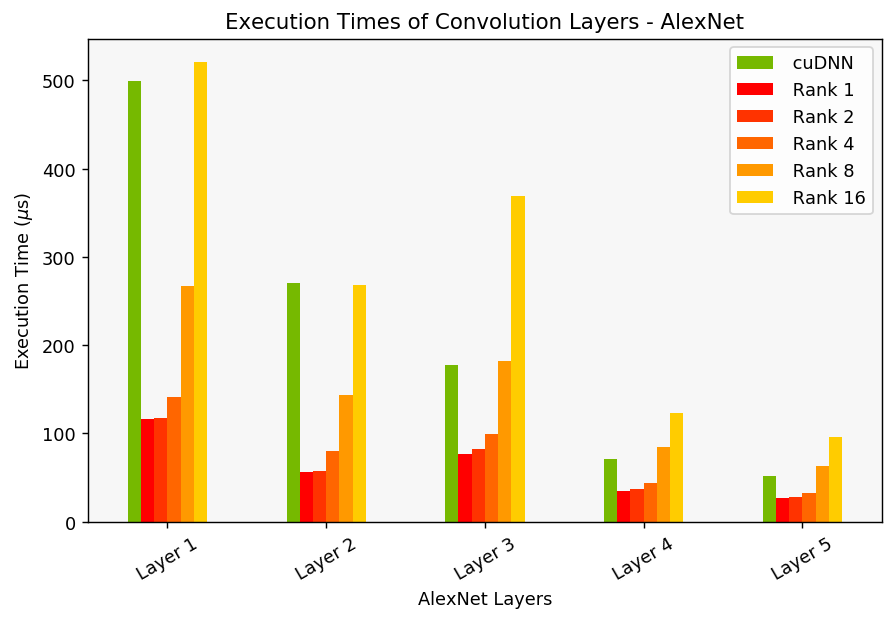

In [210]:
desc = "2080ti_190904a"
arch = "AlexNet"
    
df = pd.read_csv("BothConv2dForward_results_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])
plot2dRankTime(df, arch, color)

In [189]:
def plot2dRankFlop(df, arch, color, mod=""):
    fig = plt.figure(figsize=(8, 5), dpi=128)
    ax = fig.add_subplot(1,1,1)
    ax.set_title('TFLOP/s of Convolution Layers - ' + arch, fontsize=12)
    ax.set_ylabel(r'TFLOPs')
    ax.set_facecolor('0.97')

    df.plot.bar(ax=ax, color=color)
    plt.xticks(np.arange(5) , ["Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"])
    ax.set_xlabel(arch + " Layers")
    plt.xticks(rotation=30)
    tikzplotlib.save(arch+mod+'_flop_plot.tex')
    df.to_latex(arch+mod+'_flop_table.tex')
    plt.savefig(arch+mod+'_flop_plot.png')

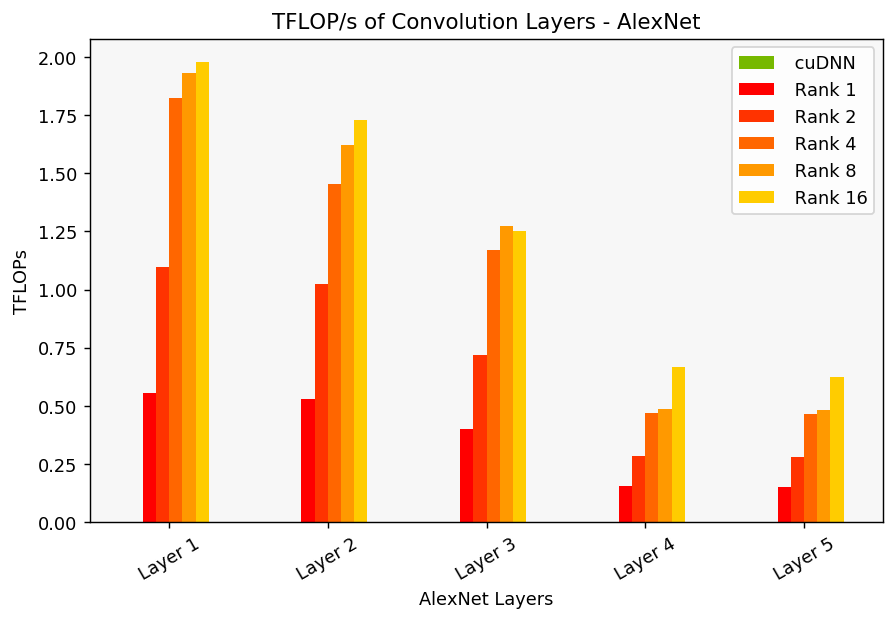

In [211]:
flopdf = pd.read_csv("BothConv2dForward_results_flop_2080ti_190908a_alexnet.txt").set_index(["N C H W pad T Y X"])
df = pd.read_csv("BothConv2dForward_results_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])

plot2dRankFlop((flopdf/(df/1e6))/1e12, arch, color)

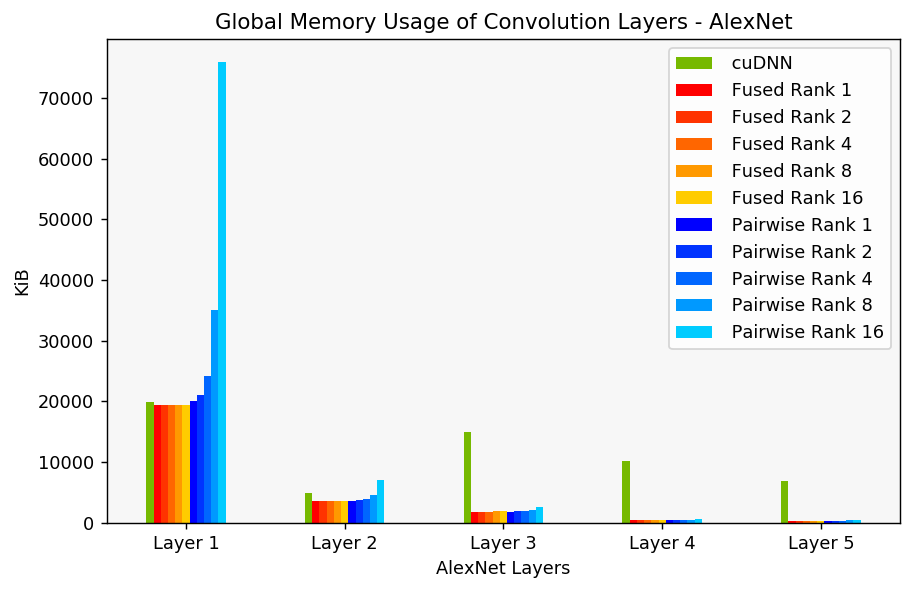

In [255]:
desc = "2080ti_190908a"
arch = "AlexNet"
    
in_df = pd.read_csv("BothConv2dForward_results_in_mem_bytes_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])
fi_df = pd.read_csv("BothConv2dForward_results_filter_mem_bytes_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])
ou_df = pd.read_csv("BothConv2dForward_results_out_mem_bytes_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])
wo_df = pd.read_csv("BothConv2dForward_results_work_mem_bytes_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])

def plot2dRankMem(df, arch, color):
    fig = plt.figure(figsize=(8, 5), dpi=128)
    ax = fig.add_subplot(1,1,1)
    ax.set_title('Global Memory Usage of Convolution Layers - ' + arch, fontsize=12)
    ax.set_ylabel(r'KiB')
    ax.set_facecolor('0.97')
#     ax.set_yscale('log')

    df.plot.bar(ax=ax, color=color)
    plt.xticks(np.arange(5) , ["Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"])
    ax.set_xlabel(arch + " Layers")
    plt.xticks(rotation=0)
    tikzplotlib.save(arch+'_mem_plot.tex')
    df.to_latex(arch+'_mem_table.tex')
    plt.savefig(arch+'_mem_plot.png')
    
plot2dRankMem((in_df+fi_df+ou_df+wo_df)/1024, arch, color)

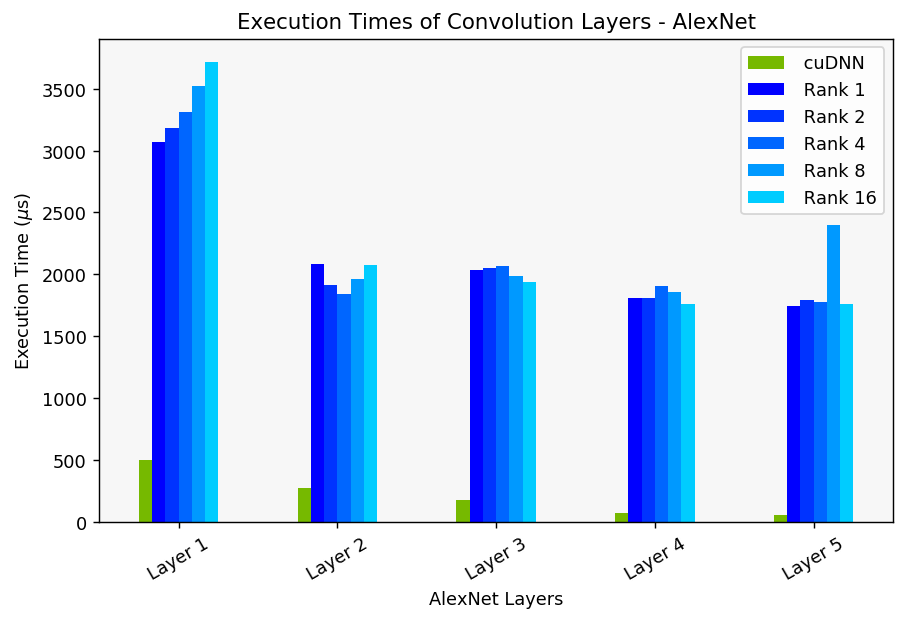

In [260]:
time_file='BothConv2dForward_results_tf_pairwise_time_2080_ti_190908a_alexnet.txt'
time_df = pd.read_csv(time_file).set_index(["N C H W pad T Y X"])
time_df
plot2dRankTime(time_df, arch, [color[0], *color[6:]], "_pairwise_")

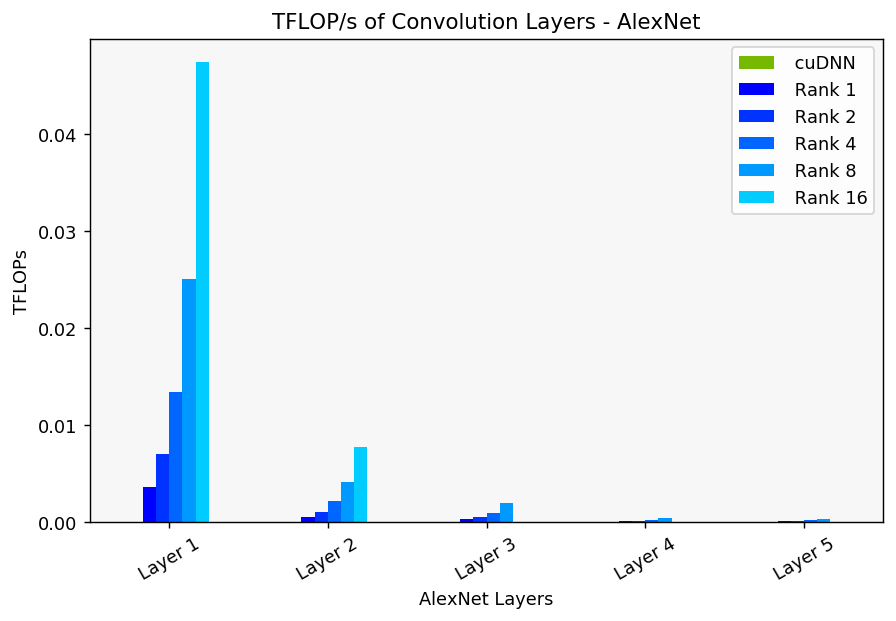

In [217]:
flopdf = pd.read_csv("BothConv2dForward_results_flop_tf_pairwise_2080ti_190908a_alexnet.txt").set_index(["N C H W pad T Y X"])
# df = pd.read_csv("BothConv2dForward_results_"+desc+"_"+arch+".txt").set_index(["N C H W pad T Y X"])
time_file='BothConv2dForward_results_tf_pairwise_time_2080_ti_190908a_alexnet.txt'
df = pd.read_csv(time_file).set_index(["N C H W pad T Y X"])
plot2dRankFlop((flopdf/(df/1e6))/1e12, arch, [color[0], *color[6:]], "_pairwise_")

In [258]:
layers=[(3,224,224,96,11,11),
        (48,55,55,256,5,5),
        (256,27,27,384,3,3),
        (192,13,13,384,3,3),
        (192,13,13,256,3,3)]

for l in layers:
    for r in [1,2,4,8,16]:
        U=(l[0]*l[1]*l[2])  # Input Feature Tensor
        S=(l[0]*r)          # In channel filter
        H=(l[4]*r)          # Height filter
        W=(l[5]*r)          # Width filter
        T=(l[3]*r)          # Out channel filter
        Us=(l[1]*l[2]*r)    # Intermediate U1
        Ush=(l[1]*l[2]*r*r) # Intermediate U2
        Ushw=(l[1]*l[2]*r)  # Intermediate U3
        V=(l[1]*l[2]*l[3])  # Final Output V
        tot = (U+S+H+W+Us+Ush+Ushw+V)*4 # Sum all * 4 bytes per float
        print(tot/1024, end=", ")
    print()

19992.09765625, 20972.1953125, 24108.390625, 35084.78125, 75853.5625, 
3627.86328125, 3687.171875, 3876.6875, 4539.3125, 6998.9375, 
1832.06640625, 1847.328125, 1894.9375, 2058.5, 2659.0, 
383.00390625, 387.078125, 399.1875, 439.25, 582.75, 
298.50390625, 302.578125, 314.6875, 354.75, 498.25, 
